# Topic 2: Recommendation System
### Demo: Underthesea, Gemsim, Cosin Similarity

In [1]:
!pip install gensim
!pip install underthesea

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 657.8/657.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 29.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel, cosine_similarity
from underthesea import word_tokenize, pos_tag, sent_tokenize
import warnings
from gensim import corpora, models, similarities
import re

In [3]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

%cd '/content/gdrive/MyDrive/LDS0/Topic_11_Agoda/demo'

Mounted at /content/gdrive
/content/gdrive/MyDrive/LDS0/Topic_11_Agoda/demo


In [4]:
STOP_WORD_FILE = 'files/vietnamese-stopwords.txt'

In [5]:
with open(STOP_WORD_FILE, 'r', encoding='utf-8') as file:
    stop_words = file.read()

stop_words = stop_words.split('\n')

# Underthesea
#### word_tokenize, pos_tag, sent_tokenize
- link: https://github.com/undertheseanlp/underthesea

In [6]:
# Dữ liệu thử nghiệm
df= pd.read_csv('hotel_info_temp.csv')

In [7]:
# Tạo nội dung tổng hợp
# Lựa chọn các thông tin cần thiết để đưa vào phần content (giúp đề xuất nội dung)
# Có thể 1 cột hoặc nhiều cột thông tin
# ví dụ ở đây là chọn 1 cột, và chỉ lấy 200 từ đầu tiên trong phần mô tả (dễ quan sát khi làm demo)
df['Content'] = df['Hotel_Description'].apply(lambda x: ' '.join(x.split()[:200]))

In [8]:
df.head()

,Hotel_ID,Hotel_Name,Hotel_Description,Content
0,1_1,Khách sạn Mường Thanh Luxury Nha Trang (Muong ...,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...
1,1_2,ALPHA BIRD NHA TRANG,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...
2,1_3,Khách sạn Aaron (Aaron Hotel),Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...,Khách sạn Aaron - Nơi nghỉ dưỡng tuyệt vời tại...
3,1_4,Panorama Star Beach Nha Trang,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...,Panorama Star Beach Nha Trang - Một kỳ nghỉ tu...
4,1_5,Khách sạn Balcony Nha Trang (Balcony Nha Trang...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...,Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...


In [9]:
# word_tokenize
df["Content_wt"]=df["Content"].apply(lambda x: word_tokenize(x, format="text"))

In [10]:
df[["Content", "Content_wt"]].head(2)

,Content,Content_wt
0,Khách sạn Mường Thanh Luxury Nha Trang - Nơi l...,Khách_sạn Mường_Thanh_Luxury Nha_Trang - Nơi l...
1,ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...,ALPHA BIRD NHA_TRANG - Khách_sạn 4.0_sao tại N...


In [11]:
import re

# Cosine_similarity
- link https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.cosine_similarity.html
- link https://en.wikipedia.org/wiki/Cosine_similarity
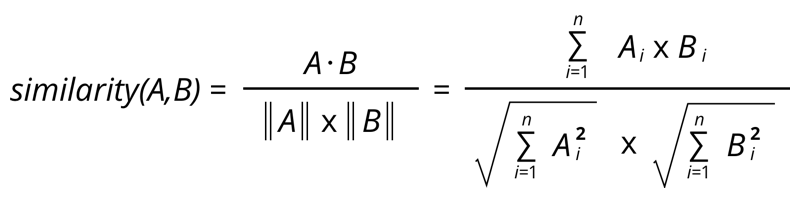

In [12]:
from numpy import dot
from numpy.linalg import norm
A = [1,2]
B = [2,2]
cos_sim = dot(A,B) / (norm(A)*norm(B))
print(cos_sim)

0.9486832980505138


In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Vector hóa nội dung
vectorizer = TfidfVectorizer(analyzer='word', stop_words=stop_words)
tfidf_matrix = vectorizer.fit_transform(df['Content_wt'])

# Tính toán độ tương đồng
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

In [14]:
df_show = pd.DataFrame(cosine_sim)
df_show

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000,0.452265,0.379586,0.358393,0.447494,0.423218,0.343525,0.347568,0.398757,0.212088,0.395496,0.384214,0.461839,0.213392,0.496867
1,0.452265,1.000000,0.433229,0.393417,0.484530,0.374749,0.403828,0.315646,0.442339,0.187938,0.431640,0.475955,0.467149,0.304308,0.565215
2,0.379586,0.433229,1.000000,0.343398,0.477965,0.360765,0.409640,0.328716,0.356086,0.179943,0.446213,0.450247,0.355218,0.353031,0.450842
3,0.358393,0.393417,0.343398,1.000000,0.449986,0.308507,0.315858,0.312088,0.295983,0.186950,0.355475,0.418662,0.361195,0.273485,0.437787
4,0.447494,0.484530,0.477965,0.449986,1.000000,0.358250,0.419528,0.322134,0.357274,0.155035,0.438654,0.471950,0.422758,0.338788,0.490850
5,0.423218,0.374749,0.360765,0.308507,0.358250,1.000000,0.288810,0.276066,0.387175,0.177318,0.309663,0.444279,0.338383,0.237497,0.454874
6,0.343525,0.403828,0.409640,0.315858,0.419528,0.288810,1.000000,0.376751,0.410945,0.170817,0.378362,0.357684,0.337836,0.252046,0.468415
7,0.347568,0.315646,0.328716,0.312088,0.322134,0.276066,0.376751,1.000000,0.367051,0.142489,0.363768,0.322367,0.279357,0.268294,0.373993
8,0.398757,0.442339,0.356086,0.295983,0.357274,0.387175,0.410945,0.367051,1.000000,0.209829,0.427379,0.375231,0.369816,0.226094,0.430054
9,0.212088,0.187938,0.179943,0.186950,0.155035,0.177318,0.170817,0.142489,0.209829,1.000000,0.172732,0.195628,0.166858,0.131683,0.274840


In [15]:
# Hàm đề xuất khách sạn
# # với mỗi sản phẩm, lấy nums sản phẩm tương quan nhất
def get_recommendations(hotel_id, cosine_sim=cosine_sim, nums=5):
    idx = df.index[df['Hotel_ID'] == hotel_id][0]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:nums+1]  # Lấy 5 khách sạn tương tự nhất
    hotel_indices = [i[0] for i in sim_scores]
    return df['Hotel_Name'].iloc[hotel_indices]

In [16]:
# Gọi function
recommendations = get_recommendations('1_1')
print(recommendations)

14    Khách Sạn Erica Nha Trang (Erica Nha Trang Hotel)
12    Senkotel Nha Trang do NEST Group quản lý (Senk...
1                                  ALPHA BIRD NHA TRANG
4     Khách sạn Balcony Nha Trang (Balcony Nha Trang...
5     Căn hộ Kymodo Panorama (Kymodo Panorama Apartm...
Name: Hotel_Name, dtype: object


#### Lưu ma trận kết quả consin và đọc lên khi cần đề xuất

In [27]:
# Save cosine_sim to file
import pickle
with open('cosine_sim.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

# Open and read file to cosine_sim_new
with open('cosine_sim.pkl', 'rb') as f:
    cosine_sim_new = pickle.load(f)
# cosine_sim_new

In [25]:
def get_recommendations(df, hotel_id, cosine_sim=cosine_sim, nums=5):
    # Get the index of the hotel that matches the hotel_id
    matching_indices = df.index[df['Hotel_ID'] == hotel_id].tolist()
    if not matching_indices:
        print(f"No hotel found with ID: {hotel_id}")
        return pd.DataFrame()  # Return an empty DataFrame if no match
    idx = matching_indices[0]

    # Get the pairwise similarity scores of all hotels with that hotel
    sim_scores = list(enumerate(cosine_sim[idx]))

    # Sort the hotels based on the similarity scores
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)

    # Get the scores of the 10 most similar hotels (Ignoring the hotel itself)
    sim_scores = sim_scores[1:nums+1]

    # Get the hotel indices
    hotel_indices = [i[0] for i in sim_scores]

    # Return the top n most similar hotels as a DataFrame
    return df.iloc[hotel_indices]

In [26]:
# Example usage (make sure to use a valid hotel_id from your DataFrame)
recommendations = get_recommendations(df, '1_1', cosine_sim=cosine_sim_new, nums=5)
print(recommendations)

   Hotel_ID                                         Hotel_Name  \
14     1_15  Khách Sạn Erica Nha Trang (Erica Nha Trang Hotel)   
12     1_13  Senkotel Nha Trang do NEST Group quản lý (Senk...   
1       1_2                               ALPHA BIRD NHA TRANG   
4       1_5  Khách sạn Balcony Nha Trang (Balcony Nha Trang...   
5       1_6  Căn hộ Kymodo Panorama (Kymodo Panorama Apartm...   

                                    Hotel_Description  \
14  Khách Sạn Erica Nha Trang - Sự Lựa Chọn Hoàn H...   
12  Senkotel Nha Trang do NEST Group quản lý - Khá...   
1   ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...   
4   Khách sạn Balcony Nha Trang - Nơi nghỉ dưỡng t...   
5   Căn hộ Kymodo Panorama - Nơi lưu trú lý tưởng ...   

                                              Content  \
14  Khách Sạn Erica Nha Trang - Sự Lựa Chọn Hoàn H...   
12  Senkotel Nha Trang do NEST Group quản lý - Khá...   
1   ALPHA BIRD NHA TRANG - Khách sạn 4.0 sao tại N...   
4   Khách sạn Balcony Nha Trang 